In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import norm
import glob
import cv2

from keras import backend as K

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda

from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, Conv2DTranspose, GaussianNoise, Reshape, MaxPooling2D
from keras.layers.normalization import BatchNormalization


Using TensorFlow backend.


In [14]:
img_size = 128

path = 'cartoonset10k/cartoonset10k/'
file_name = os.listdir(path)

l_img = []

for i in file_name:
    p = path + i
    
    img = cv2.imread(p)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size,img_size))
    
    l_img.append(img)

    
x_train = np.asarray(l_img)
x_train = x_train.astype( np.float32 )
x_train /= 255.

x_train.shape

(10000, 128, 128, 3)

In [15]:
from tensorflow.keras import backend as K
# Codes from https://keras.io/examples/variational_autoencoder/
# Reparameterization trick: instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling( args ):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    
    # By default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal( shape=(batch, dim) )  # shape = the shape of tensor to create
    
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Conv2DTranspose, GaussianNoise, Reshape, MaxPooling2D

#### 1. Input  ####
in_img = Input( shape=(img_size,img_size,3) , name='input_img')
#x = Dropout(0.2, name='denoised_img')(in_img)       # denoising AE
x = in_img

#### 2. Encode ####
x = Conv2D( 64, (3,3), activation='relu',padding='same', strides=(2,2), name='encoded1')(x)
# x = Dropout(0.2)(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D( 128, (3,3), activation='relu', padding='same', strides=(2,2),name='encoded2')(x)
# x = Dropout(0.2)(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)

# x = Conv2D( 256, (3,3), activation='relu', padding='same', strides=(2,2),name='encoded3')(x)
# # x = MaxPooling2D(pool_size=(2, 2))(x)

# x = Conv2D( 512, (3,3), activation='relu', padding='same', strides=(2,2),name='encoded4')(x)
# # x = Dropout(0.5)(x)
# # x = MaxPooling2D(pool_size=(2, 2))(x)

# x = Conv2D( 4, (3,3), activation='relu', padding='same', strides=(2,2),name='encoded5')(x)

x = Flatten()(x)
# x = Dense(512, activation='relu')(x)


latent_dim = 64
z_mean = Dense( latent_dim, name='z_mean' )(x)
z_log_var = Dense( latent_dim, name='z_log_var' )(x)

# 4. Use reparameterization trick to push the sampling out as input
z = Lambda( sampling,   # name of the function to be evaluated
                    output_shape=(latent_dim,), 
                    name='z' )( [z_mean, z_log_var] )

# Instantiate the encoder model
# 1 input is in_img
# 3 outputs include z_mean (vector of mean), z_log_var (vector of SD), z (vector of sampled points)
encoder = Model( in_img, [z_mean, z_log_var, z], name='encoder' )
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
encoded1 (Conv2D)               (None, 64, 64, 64)   1792        input_img[0][0]                  
__________________________________________________________________________________________________
encoded2 (Conv2D)               (None, 32, 32, 128)  73856       encoded1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 131072)       0           encoded2[0][0]                   
____________________________________________________________________________________________

In [17]:
#### 5. Decoder ####
latent_inputs = Input( shape=(latent_dim,), name='z_sampling' )
x = Dense( 32*32*128 , activation='relu')(latent_inputs)
x = Reshape( (32,32,128) )(x) 
# x = Conv2DTranspose( 256, (3,3), activation='relu', padding='same', strides=2, name='decoded1')(x)

# x = Conv2DTranspose( 128, (3,3), activation='relu', padding='same', strides=2, name='decoded2')(x)

x = Conv2DTranspose( 64, (3,3), activation='relu', padding='same', strides=2, name='decoded3')(x)

# x = Conv2DTranspose( 32, (3,3), activation='relu', padding='same', strides=2, name='decoded4')(x)

out_img = Conv2DTranspose( 3, (3,3), activation='sigmoid', padding='same', strides=2, name='decoded5')(x)
#x = Dropout(0.2)(x)

#### 6. Output ####
#out_img = Conv2DTranspose( 3, (3,3), activation='sigmoid', padding='same', name='output_img')(x)

# Instantiate the encoder model
decoder = Model( latent_inputs, out_img, name='decoder' )
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 64)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 131072)            8519680   
_________________________________________________________________
reshape_1 (Reshape)          (None, 32, 32, 128)       0         
_________________________________________________________________
decoded3 (Conv2DTranspose)   (None, 64, 64, 64)        73792     
_________________________________________________________________
decoded5 (Conv2DTranspose)   (None, 128, 128, 3)       1731      
Total params: 8,595,203
Trainable params: 8,595,203
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Among the three outputs of 'encoder', send only the last one (= 'z') to 'decoder'
vae_out = decoder( encoder(in_img)[2] )

# Instantiate VAE model
model = Model( in_img, vae_out, name='vae_mlp' )

model.summary()

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 128, 128, 3)]     0         
_________________________________________________________________
encoder (Model)              [(None, 64), (None, 64),  16852992  
_________________________________________________________________
decoder (Model)              (None, 128, 128, 3)       8595203   
Total params: 25,448,195
Trainable params: 25,448,195
Non-trainable params: 0
_________________________________________________________________


In [19]:
from tensorflow.keras.losses import mse, binary_crossentropy
def vae_loss ( y_true, y_pred ):
    # Original reconstruction loss: two options
    # recon_loss = mse( y_true, y_pred )
    recon_loss = binary_crossentropy( y_true, y_pred )
    recon_loss *= img_size*img_size*3
    
    # Extract two output vectors from the 'encoder'
    z_mean = model.get_layer('encoder').get_layer('z_mean').output
    z_log_var = model.get_layer('encoder').get_layer('z_log_var').output
    
    # KL divergence loss
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum( kl_loss, axis=-1 )
    kl_loss *= -0.5
    
    return K.mean( recon_loss + kl_loss )

# Compile the model
model.compile( optimizer='adam', loss=vae_loss, metrics=["acc"] )

In [20]:
hist = model.fit( x_train, x_train, batch_size=1, epochs=5)
# hist = model.fit( x_train, x_train, batch_size=1, epochs=5,validation_data=[x_test, x_test])

Epoch 1/5
10000/10000 [==============================] - 281s 28ms/sample - loss: 7097.4290 - acc: 0.4686
Epoch 2/5
10000/10000 [==============================] - 279s 28ms/sample - loss: 6287.1130 - acc: 0.2875
Epoch 3/5
10000/10000 [==============================] - 280s 28ms/sample - loss: 6169.8057 - acc: 0.2423
Epoch 4/5
10000/10000 [==============================] - 282s 28ms/sample - loss: 6119.6384 - acc: 0.2363
Epoch 5/5
10000/10000 [==============================] - 281s 28ms/sample - loss: 6091.1609 - acc: 0.2346


In [21]:
model.save('vae1.h5')

dict_keys(['loss', 'acc'])


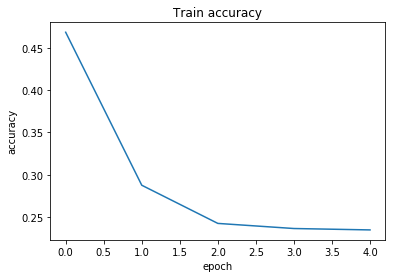

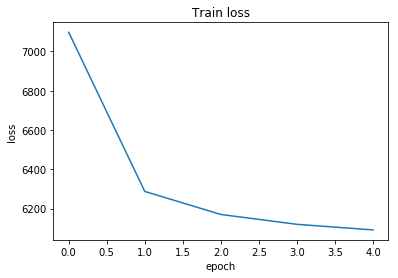

In [22]:
# List all data in history
print( hist.history.keys())
# Summarize history for accuracy
plt.plot(hist.history['acc'])
#plt.plot(hist.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(hist.history['loss'])
#plt.plot(hist.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()

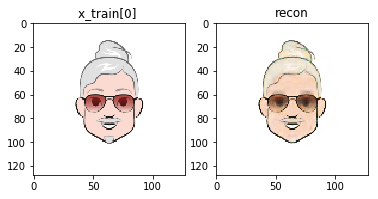

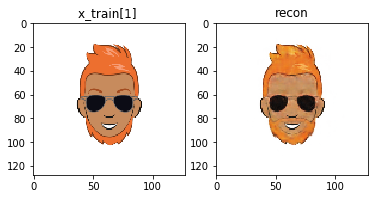

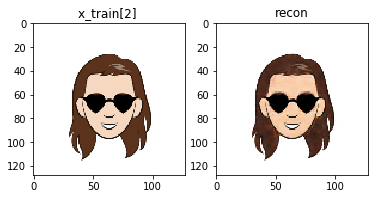

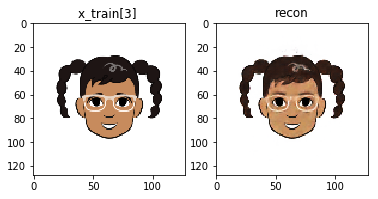

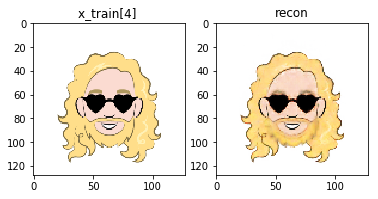

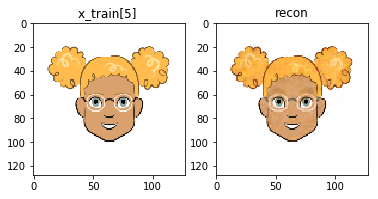

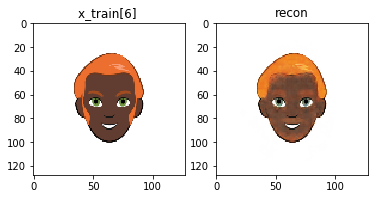

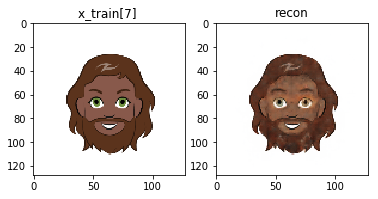

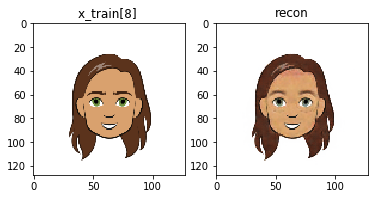

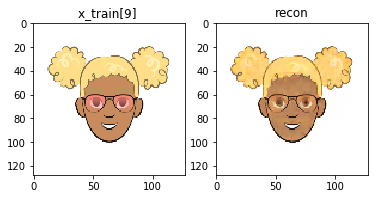

In [23]:
n = 10
for i in range(n):
    x_recon = model.predict( np.array ( [x_train[i] ] ) )

    plt.subplot(1,2,1).set_title( 'x_train[' + str(i) +'] ')            
    plt.imshow( x_train[i].reshape(img_size,img_size,3) )
    
    plt.subplot(1,2,2).set_title( 'recon' )               
    plt.imshow( x_recon.reshape(img_size,img_size,3)  )  
    
    plt.show()

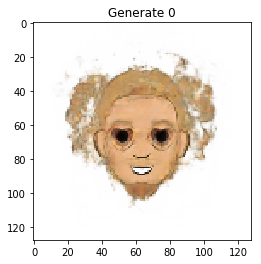

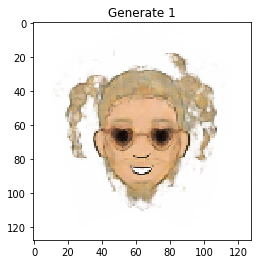

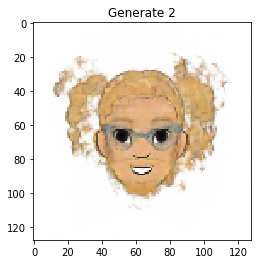

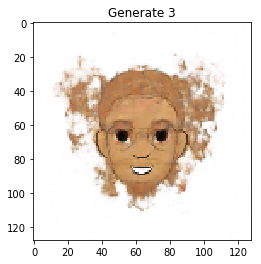

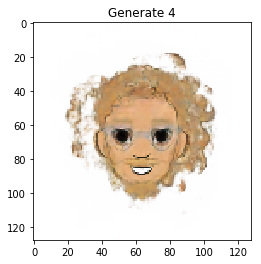

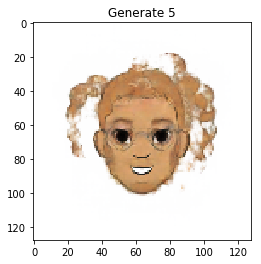

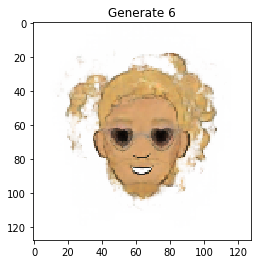

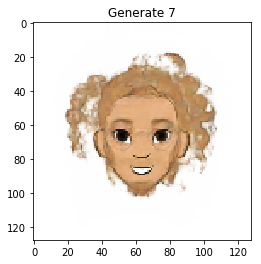

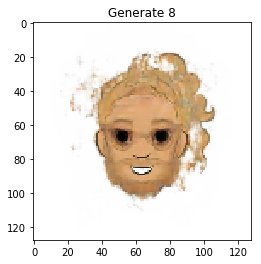

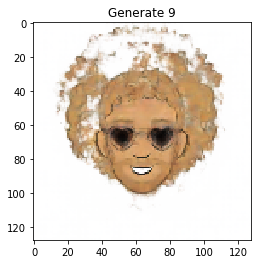

In [26]:
n = 10
for i in range(n):
    z = np.random.randint(1000, size=(1,latent_dim ))/1000
    x_decoded = decoder.predict( z )

    plt.title( "Generate {}".format(i) )
    plt.imshow( x_decoded.reshape(img_size,img_size,3)  )  
    
    plt.show()